In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
umich = pd.read_csv('../data/umich.csv',index_col=0)
umich = umich[umich['Run'] != 'R16']

In [3]:
def rolling_avg(run_df,window_size=300):
    list_of_pressure_names = ['p1','p2','p3','p4','p5']
    for px in list_of_pressure_names:
        run_df[px+'rol_avg'] = run_df[px].rolling(window_size).mean()
    for px in list_of_pressure_names:
        run_df[px+'rol_med'] = run_df[px].rolling(window_size).median()
    #for px in list_of_pressure_names:
        #run_df[px+'rol_var'] = run_df[px].rolling(window_size).var()
    #for px in list_of_pressure_names:
        #run_df[px+'rol_var'] = run_df[px].rolling(window_size).std()
        
    run_df = run_df.fillna(0)
    return run_df

In [4]:
runs = umich['Run'].unique()
variables = {}

# Loop through a range of values
for i in runs:
    # Create a new variable name
    variable_name = f"{i}"
    
    # Create a new variable value
    variable_value = umich[umich['Run']==i]
    
    # Assign the variable value to the variable name in the dictionary
    variables[variable_name] = variable_value.reset_index(drop=True)

for variable_name, variable_value in variables.items():
    globals()[variable_name] = variable_value
    
df_list = [R0, R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11,
           R12, R13, R14, R15, R17, R18, R19, R20, R21,
           R22, R23, R24, R25, R26, R27, R28, R29, R30, R31,
           R32, R33, R34, R35, R36, R37] # Note: R16 is dropped because of NaN values.

pressure_transducers = ['p1','p2','p3','p4','p5']
location_list = ['px1','px2','px3','px4','px5']

In [5]:
train_run = ['R0','R8','R2','R12','R32','R24','R36']

test_run = ['R28','R29','R30','R31','R37','R21','R6','R9','R10',
             'R11','R23','R33','R35','R24','R27','R13','R14','R15','R20',
            'R1','R3','R4','R5','R7','R17','R18','R19','R22','R25','R26']

train_set = umich[umich['Run'].isin(train_run)]
test_set = umich[umich['Run'].isin(test_run)]

In [6]:
# Generates a dataframe with rolling averages & mean
variables = {}
for i in train_run:
    # Create a new variable name
    variable_name = f"train_{i}"
    
    # Create a new variable value
    variable_value = train_set[train_set['Run']==i]
    
    # Assign the variable value to the variable name in the dictionary
    variables[variable_name] = variable_value.reset_index(drop=True)

for variable_name, variable_value in variables.items():
    globals()[variable_name] = variable_value
    
df_list = [R0, R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11,
           R12, R13, R14, R15, R17, R18, R19, R20, R21,
           R22, R23, R24, R25, R26, R27, R28, R29, R30, R31,
           R32, R33, R34, R35, R36, R37] # Note: R16 is dropped because of NaN values.

In [7]:
list_of_rolled_df_train = []
list_of_rolled_df_test = []

for i in train_run:
    list_of_rolled_df_train.append(rolling_avg(umich[umich['Run']==i]))
for i in test_run:
    list_of_rolled_df_test.append(rolling_avg(umich[umich['Run']==i]))

In [8]:
full_rolled_train = pd.concat(list_of_rolled_df_train)
full_rolled_test = pd.concat(list_of_rolled_df_test)

In [9]:
full_rolled_train = full_rolled_train[full_rolled_train['time']>=0.0300]
full_rolled_test = full_rolled_test[full_rolled_test['time']>=0.0300]

# UMICH Neural Network

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [11]:
def RunNeuralNet(train_df, test_df):
    X_train = train_df.drop(['x1','time','Run','H','W'],axis=1)
    X_test = test_df.drop(['x1','time','Run','H','W'],axis=1)
    y_train = train_df['x1']
    y_test = test_df['x1']

    ss = StandardScaler()

    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    model = Sequential()

    model.add(Dense(20, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam',loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    
    model.fit(x=X_train_scaled,y=y_train.values,
          validation_data=(X_test_scaled,y_test.values),
          batch_size=128,epochs=100,callbacks=[early_stopping])
    
    y_pred = model.predict(X_test_scaled)
    test_df = test_df.copy()
    test_df['pred'] = y_pred
    
    return test_df,model

In [12]:
test_df,model = RunNeuralNet(full_rolled_train, full_rolled_test)

Epoch 1/100
1686/1686 [==============================] - 3s 1ms/step - loss: 71558.4141 - val_loss: 1394.0651
Epoch 2/100
1686/1686 [==============================] - 2s 1ms/step - loss: 521.8706 - val_loss: 449.6395
Epoch 3/100
1686/1686 [==============================] - 2s 1ms/step - loss: 157.1781 - val_loss: 273.8268
Epoch 4/100
1686/1686 [==============================] - 2s 1ms/step - loss: 97.1623 - val_loss: 181.0482
Epoch 5/100
1686/1686 [==============================] - 2s 1ms/step - loss: 67.0939 - val_loss: 126.5648
Epoch 6/100
1686/1686 [==============================] - 2s 1ms/step - loss: 50.6237 - val_loss: 95.8275
Epoch 7/100
1686/1686 [==============================] - 2s 1ms/step - loss: 41.9181 - val_loss: 77.5513
Epoch 8/100
1686/1686 [==============================] - 2s 1ms/step - loss: 36.5715 - val_loss: 65.7727
Epoch 9/100
1686/1686 [==============================] - 2s 1ms/step - loss: 31.9944 - val_loss: 54.7910
Epoch 10/100
1686/1686 [====================

In [14]:
model.save("model_significant")

INFO:tensorflow:Assets written to: model_significant/assets


INFO:tensorflow:Assets written to: model_significant/assets


# Transfer Learning Method (AFIT)

In [15]:
afit = pd.read_csv('../data/afit.csv',index_col=0)

In [16]:
R6 = afit[afit['Run']=='R6']
R7 = afit[afit['Run']=='R7']
R8 = afit[afit['Run']=='R8']

run_list = [R6,R7,R8]

In [17]:
train = R8.drop(['time','Run'],axis=1)
test = pd.concat([R6,R7])
test = test.drop(['time','Run'],axis=1)

In [18]:
X_train = train.drop('x1',axis=1)
y_train = train['x1']
X_test = test.drop('x1',axis=1)
y_test = test['x1']

In [19]:
#from random import sample

#index = sample([i for i in range(31)],25)

#X_train = X_train.iloc[:,index]
#X_test = X_test.iloc[:,index]

In [20]:
train[['px2', 'px9', 'px3', 'p8', 'H', 'p7', 'W', 'px7', 'p1', 'px4', 'px6',
       'px5', 'px10', 'p2', 'px13', 'px12', 'L', 'p14', 'px8', 'p12']]

,px2,px9,px3,p8,H,p7,W,px7,p1,px4,px6,px5,px10,p2,px13,px12,L,p14,px8,p12
3665,2.57,10.88,3.76,5.236325,2.5,5.436452,2.5,8.51,4.594629,4.94,7.32,6.13,12.07,5.004554,18.01,15.64,5.05,9.348691,9.7,5.855930
3666,2.57,10.88,3.76,5.344038,2.5,5.343885,2.5,8.51,4.540004,4.94,7.32,6.13,12.07,5.107406,18.01,15.64,5.05,9.104833,9.7,5.749688
3668,2.57,10.88,3.76,5.248293,2.5,5.413310,2.5,8.51,4.528222,4.94,7.32,6.13,12.07,4.922504,18.01,15.64,5.05,9.359854,9.7,5.827807
3669,2.57,10.88,3.76,5.248293,2.5,5.390168,2.5,8.51,4.551786,4.94,7.32,6.13,12.07,5.053091,18.01,15.64,5.05,9.109126,9.7,5.827807
3670,2.57,10.88,3.76,5.272229,2.5,5.413310,2.5,8.51,4.550715,4.94,7.32,6.13,12.07,5.062336,18.01,15.64,5.05,9.288585,9.7,5.640322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9675,2.57,10.88,3.76,5.367974,2.5,5.274460,2.5,8.51,4.544288,4.94,7.32,6.13,12.07,4.968730,18.01,15.64,5.05,11.175057,9.7,5.745001
9676,2.57,10.88,3.76,5.248293,2.5,5.297602,2.5,8.51,4.564639,4.94,7.32,6.13,12.07,4.912103,18.01,15.64,5.05,11.190512,9.7,5.710629
9677,2.57,10.88,3.76,5.427814,2.5,5.459593,2.5,8.51,4.552857,4.94,7.32,6.13,12.07,5.002243,18.01,15.64,5.05,11.278954,9.7,5.568452
9678,2.57,10.88,3.76,5.248293,2.5,5.413310,2.5,8.51,4.500374,4.94,7.32,6.13,12.07,4.973352,18.01,15.64,5.05,11.143286,9.7,6.041853


In [21]:
full_rolled_train.drop(['x1','time','Run','H','W'],axis=1)

,px1,px2,px3,px4,px5,p1,p2,p3,p4,p5,p1rol_avg,p2rol_avg,p3rol_avg,p4rol_avg,p5rol_avg,p1rol_med,p2rol_med,p3rol_med,p4rol_med,p5rol_med
300,521.81,565.50,609.19,652.88,696.56,12.355939,13.779516,13.556960,13.681496,21.352370,12.331946,13.846762,13.598779,13.687306,21.523088,12.330907,13.844427,13.598982,13.688735,21.524585
301,521.81,565.50,609.19,652.88,696.56,12.270692,13.872969,13.582306,13.644854,21.098136,12.331906,13.846919,13.598563,13.687209,21.520972,12.330907,13.845023,13.598664,13.688735,21.519387
302,521.81,565.50,609.19,652.88,696.56,12.298726,13.803103,13.507869,13.695163,21.272297,12.331650,13.847013,13.598252,13.687361,21.520396,12.330864,13.845023,13.597319,13.689154,21.519387
303,521.81,565.50,609.19,652.88,696.56,12.328403,13.871828,13.585113,13.667733,21.157165,12.331692,13.847002,13.597987,13.687236,21.518629,12.330864,13.845023,13.595979,13.688735,21.517463
304,521.81,565.50,609.19,652.88,696.56,12.390785,13.869426,13.562293,13.727346,21.194928,12.331551,13.847155,13.597627,13.687157,21.518942,12.330864,13.845280,13.595772,13.688735,21.517463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151546,652.88,652.88,554.58,554.58,954.25,24.562436,24.336266,13.854998,14.576567,36.500594,25.006276,24.110565,13.895970,14.629862,37.412470,24.982840,24.122683,13.895236,14.627252,37.387133
1151547,652.88,652.88,554.58,554.58,954.25,24.704884,23.899200,13.817422,14.593787,36.365112,25.003192,24.103203,13.895854,14.629933,37.414066,24.981202,24.105812,13.895236,14.627252,37.387133
1151548,652.88,652.88,554.58,554.58,954.25,24.765968,23.525704,13.973813,14.551239,35.919355,25.000225,24.097661,13.895937,14.629723,37.410072,24.980951,24.090724,13.895236,14.627252,37.387133
1151549,652.88,652.88,554.58,554.58,954.25,24.287354,22.970264,13.905415,14.583904,37.187635,24.994830,24.092689,13.895912,14.629803,37.406401,24.976727,24.084342,13.895236,14.627252,37.382010


In [22]:
X_train = train[['px2', 'px9', 'px3', 'p8', 'H', 'p7', 'W', 'px7', 'p1', 'px4', 'px6',
       'px5', 'px10', 'p2', 'px13', 'px12', 'L', 'p14', 'px8', 'p12']]

X_test = test[['px2', 'px9', 'px3', 'p8', 'H', 'p7', 'W', 'px7', 'p1', 'px4', 'px6',
      'px5', 'px10', 'p2', 'px13', 'px12', 'L', 'p14', 'px8', 'p12']]

In [23]:
from tensorflow.keras.models import load_model

In [24]:
base_model = load_model('model.h5')

In [25]:
new_model = Sequential()

base_model.trainable=False

new_model.add(base_model)
new_model.add(Dense(20, activation='relu'))

new_model.add(Dense(1))
              
new_model.compile(optimizer='adam',loss='mse')

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, mode='min', verbose=1)

In [27]:
result = new_model.fit(x=X_train.values,y=y_train.values,
          validation_data=(X_test.values,y_test.values),
          batch_size=100,epochs=200,callbacks=[early_stopping])

Epoch 1/200
61/61 [==============================] - 0s 2ms/step - loss: 1479.3549 - val_loss: 18.0572
Epoch 2/200
61/61 [==============================] - 0s 980us/step - loss: 6.8070 - val_loss: 0.3585
Epoch 3/200
61/61 [==============================] - 0s 979us/step - loss: 0.3974 - val_loss: 0.2709
Epoch 4/200
61/61 [==============================] - 0s 963us/step - loss: 0.3894 - val_loss: 0.2732
Epoch 5/200
61/61 [==============================] - 0s 947us/step - loss: 0.3893 - val_loss: 0.2713
Epoch 6/200
61/61 [==============================] - 0s 950us/step - loss: 0.3890 - val_loss: 0.2770
Epoch 7/200
61/61 [==============================] - 0s 941us/step - loss: 0.3892 - val_loss: 0.2765
Epoch 8/200
61/61 [==============================] - 0s 955us/step - loss: 0.3896 - val_loss: 0.2730
Epoch 9/200
61/61 [==============================] - 0s 968us/step - loss: 0.3891 - val_loss: 0.2762
Epoch 10/200
61/61 [==============================] - 0s 1ms/step - loss: 0.3891 - val_lo

<Axes: >

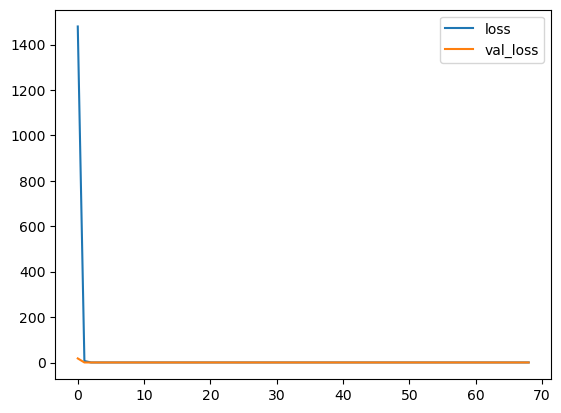

In [28]:
pd.DataFrame(result.history).plot()

In [29]:
y_pred = new_model.predict(X_test)

409/409 [==============================] - 0s 241us/step


In [30]:
test_full = afit[(afit['Run']=='R6') | (afit['Run']=='R7')]

In [31]:
test_full['pred'] = y_pred

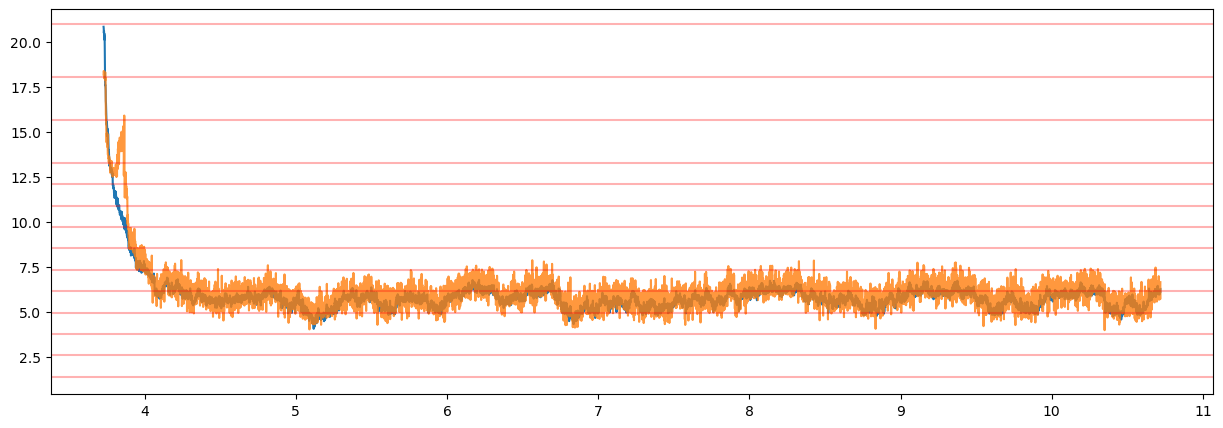

In [32]:
plt.figure(figsize=(15,5))

plt.plot(test_full[test_full['Run']=='R6']['time'],test_full[test_full['Run']=='R6']['x1'], label='True STLE')
plt.plot(test_full[test_full['Run']=='R6']['time'],test_full[test_full['Run']=='R6']['pred'],label='Predicted STLE',alpha=0.8)

for j in ['px1', 'px2', 'px3', 'px4', 'px5', 'px6', 'px7', 'px8', 'px9', 'px10',
          'px11', 'px12', 'px13', 'px14']:
    plt.axhline(test_full[j].iloc[0],color='red',alpha=.3)
    
plt.show()

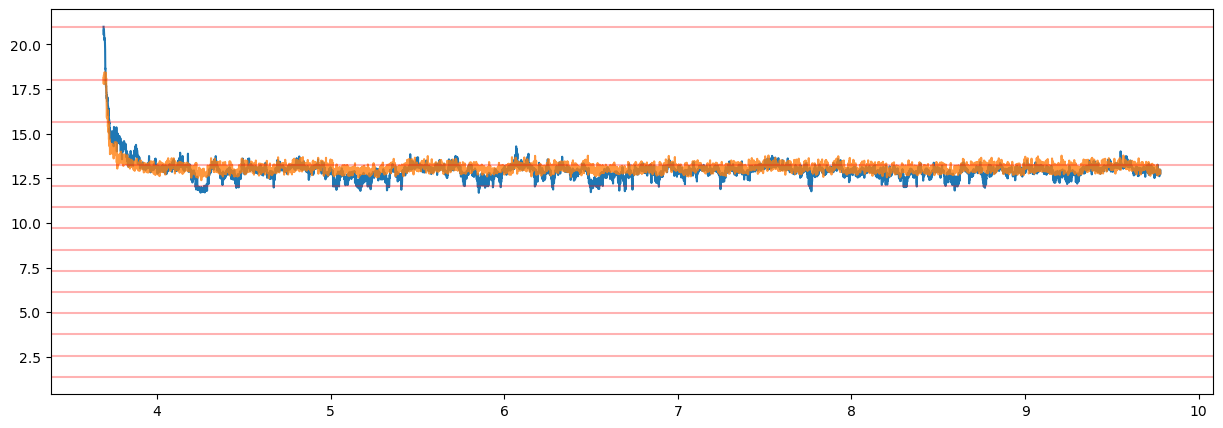

In [33]:
plt.figure(figsize=(15,5))

plt.plot(test_full[test_full['Run']=='R7']['time'],test_full[test_full['Run']=='R7']['x1'], label='True STLE')
plt.plot(test_full[test_full['Run']=='R7']['time'],test_full[test_full['Run']=='R7']['pred'],label='Predicted STLE',alpha=0.8)

for j in ['px1', 'px2', 'px3', 'px4', 'px5', 'px6', 'px7', 'px8', 'px9', 'px10',
          'px11', 'px12', 'px13', 'px14']:
    plt.axhline(test_full[j].iloc[0],color='red',alpha=.3)
    
plt.show()

In [34]:
X_train.columns

Index(['px2', 'px9', 'px3', 'p8', 'H', 'p7', 'W', 'px7', 'p1', 'px4', 'px6',
       'px5', 'px10', 'p2', 'px13', 'px12', 'L', 'p14', 'px8', 'p12'],
      dtype='object')

- ['px9', 'p8', 'px13', 'p13', 'p3', 'L', 'px8', 'p5', 'p6', 'p12', 'p11',
       'px2', 'H', 'px6', 'p4', 'p10', 'px3', 'p14', 'p7', 'px10']
- ['px2', 'px9', 'px3', 'p8', 'H', 'p7', 'W', 'px7', 'p1', 'px4', 'px6',
       'px5', 'px10', 'p2', 'px13', 'px12', 'L', 'p14', 'px8', 'p12'] (REALLY GOOD)